## A schematic of the adopted approach and the basis for <i>Sarve</i>

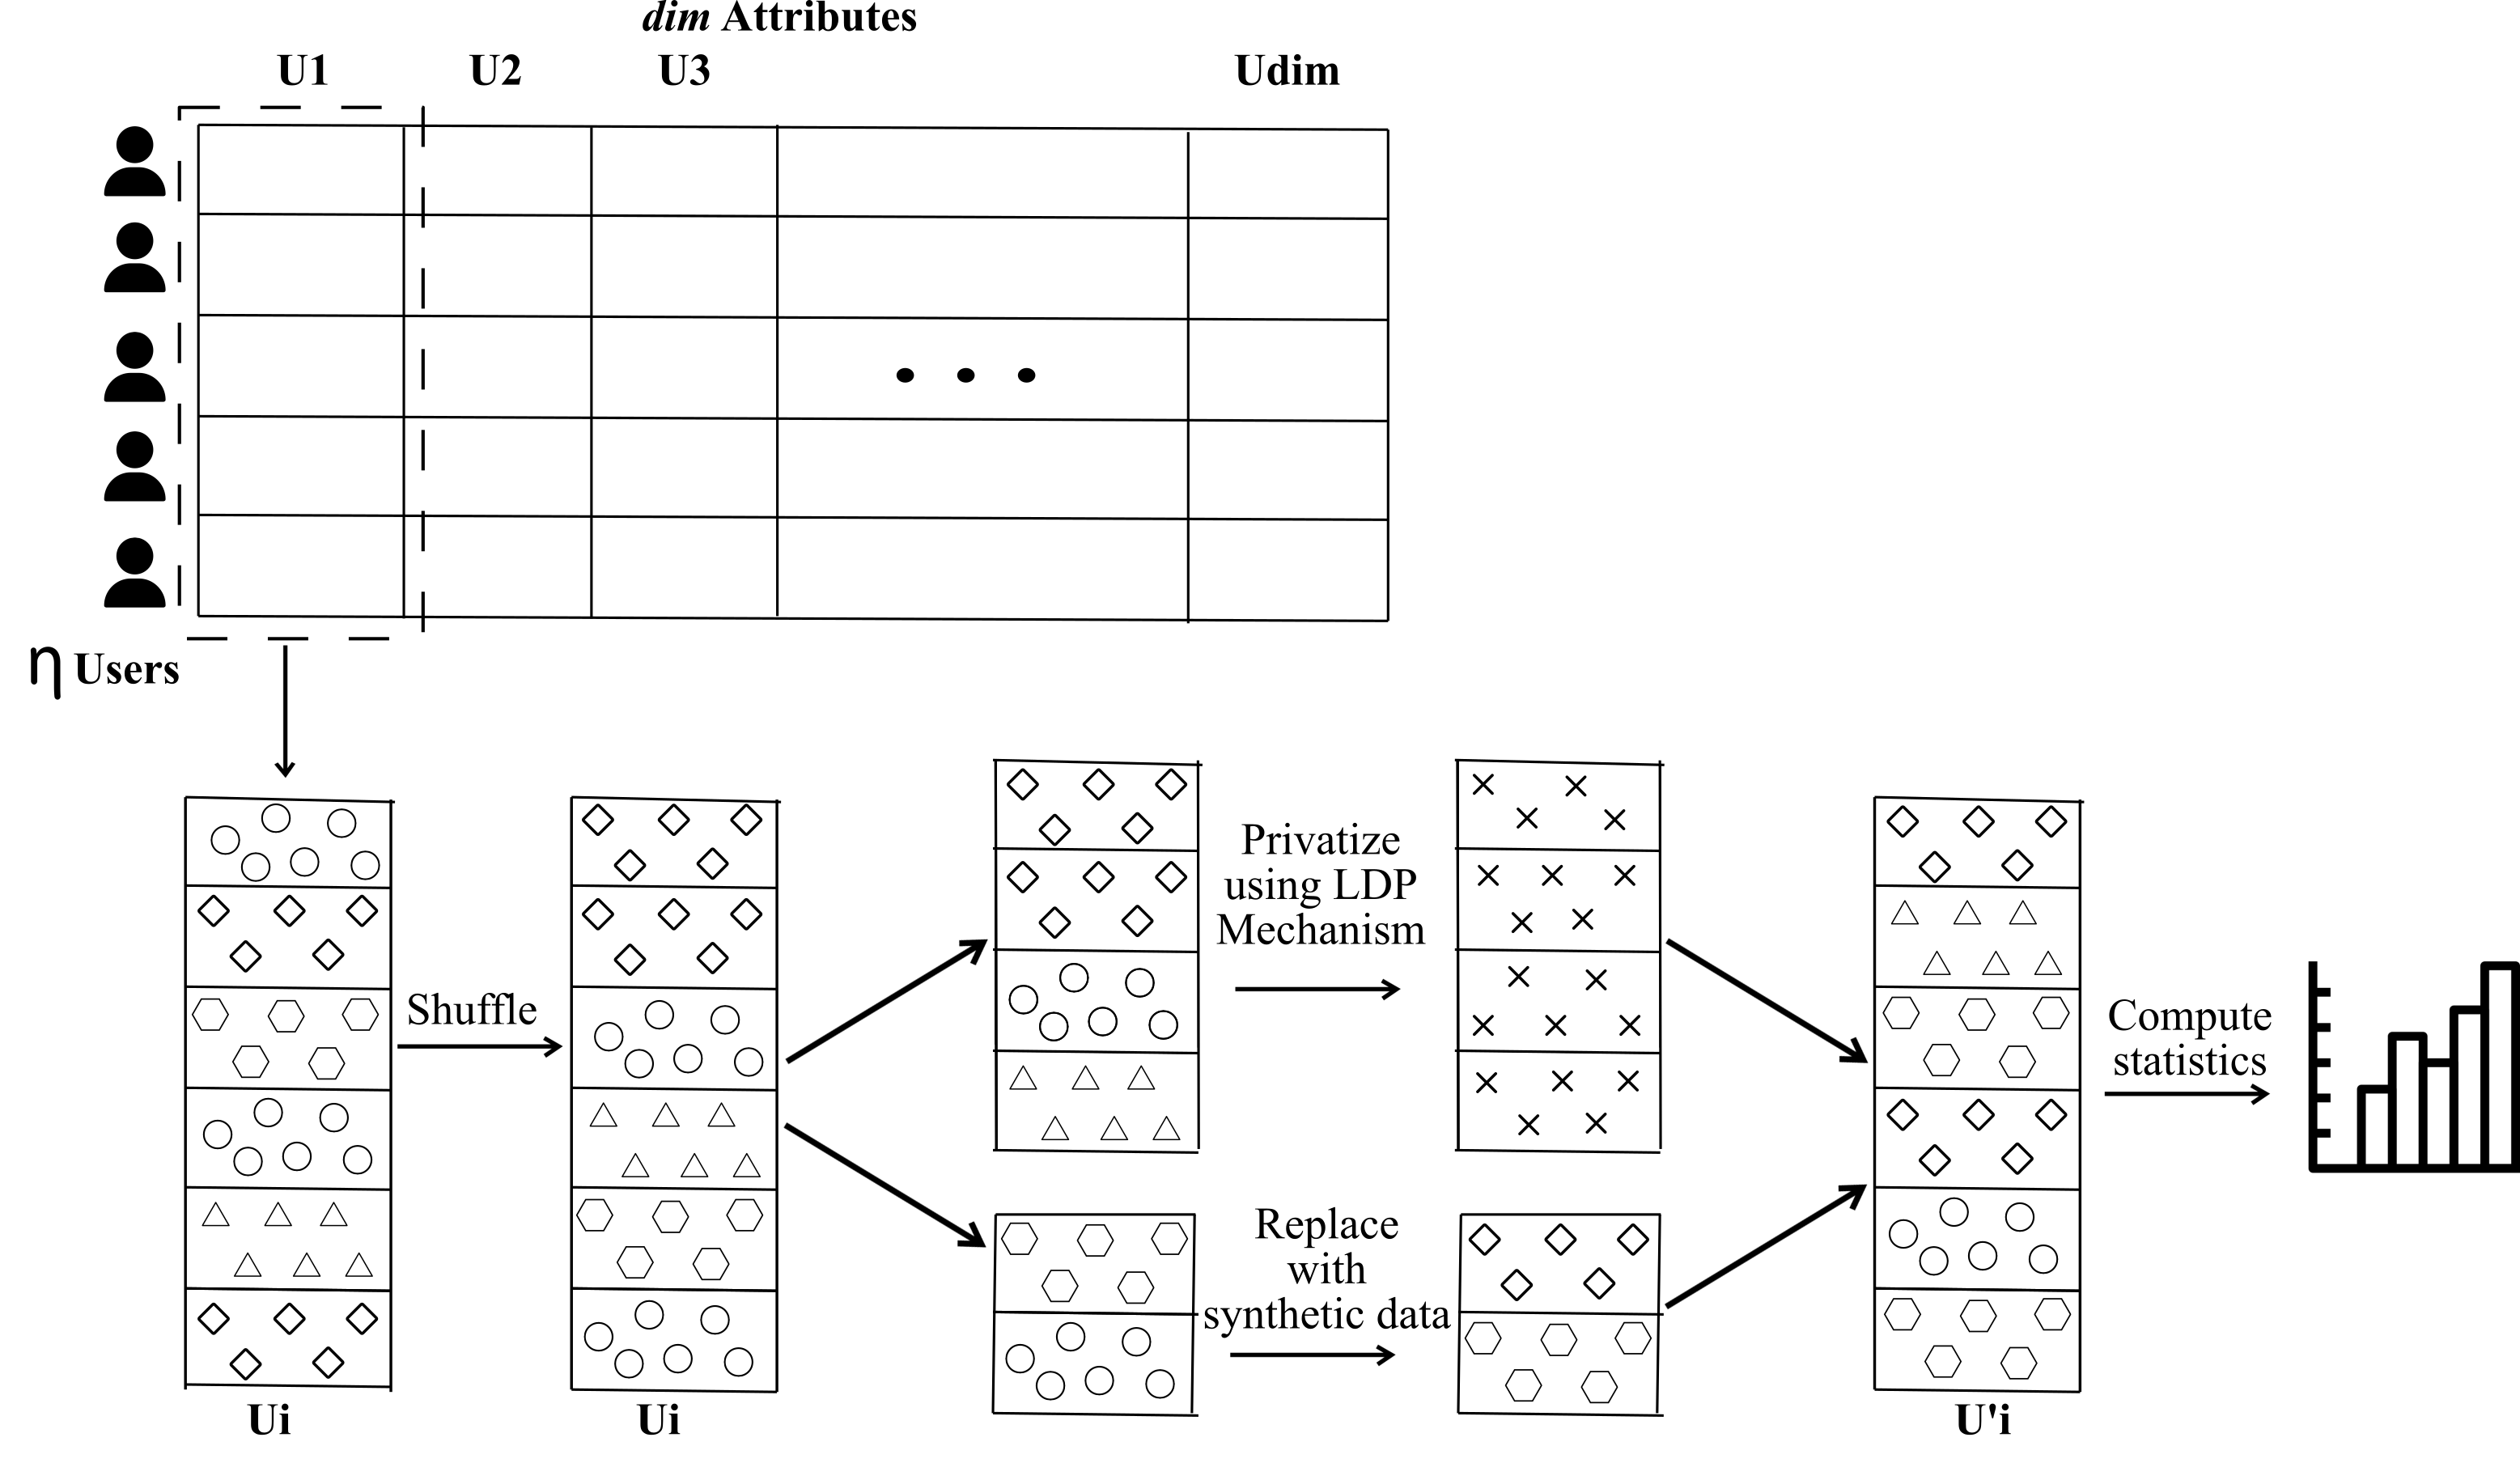

# Tests using Synthetically-generated datasets
<br>This notebook tests <i>Sarve</i> and other frequency oracles using synthetically-generated datasets having the following characteristics:
    <br>* 50,000 observations and 5 dimensions
    <br>* 50,000 observations and 10 dimensions
    <br>* 500,000 observations and 5 dimensions
    <br>* 500,000 observations and 10 dimensions
    <br>* 50,000 observations and 10 dimensions with non-uniform distribution
    <br>* 50,000 observations and 20 dimensions with non-uniform distribution
### Number of evaluations (i.e., of different seeds)

In [1]:
nb_seed = 100

## Functions to save results in csv format per method

In [1]:
# path
common_path = './results/syn/'

In [2]:
ds_path = '500K_10D_NU/'

In [3]:
priv_regime = 'highpriv/'

In [4]:
priv_regime = 'genpriv/'

In [4]:
grr_flnm = common_path + ds_path + priv_regime + 'final_results_rs_fd_grr.csv'
ouez_flnm = common_path + ds_path + priv_regime + 'final_results_oue_z.csv'
spl_flnm = common_path + ds_path + priv_regime + 'final_results_spl.csv'
smp_flnm = common_path + ds_path + priv_regime + 'final_results_smp.csv'
adp_flnm = common_path + ds_path + priv_regime + 'final_results_adp.csv'
rpr_flnm = common_path + ds_path + priv_regime + 'final_results_rappor.csv'
hdmd_flnm = common_path + ds_path + priv_regime + 'final_results_hadamard.csv'
sarve_flnm = common_path + ds_path + priv_regime + 'final_results_sarve.csv'
sarve4_flnm = common_path + ds_path + priv_regime + 'final_results_sarve4.csv'
print (sarve_flnm)

./results/syn/500K_10D_NU/highpriv/final_results_sarve.csv


In [6]:
def write_fd_to_file(values, flnm):
    with open(flnm, mode='a', newline='') as scores_file:
        scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        scores_writer.writerow(values)
    scores_file.close()

## Main libraries

In [6]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
#pd.set_option('display.max_rows', 500)
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import copy
from scipy.stats import bernoulli
import datetime
import time
import csv
from pandas.core.common import flatten
import math
import random

## Numba library for speeding up things

In [8]:
from numba import jit

## Creating synthetic dataset

In [12]:
@jit(nopython=True)
def create_dataset(n, lst_k, d):
    """This function creates uses numba to accelerate the creation of large synthetic datasets
    input: number of 'users' n, domain size of each attribute 'lst_k', and the number of attributes d.
    output: list of synthetic values per attribute
    """
    
    dic_df = []
    for idx in range(d):
        k = lst_k[idx]
        dic_df.append([np.random.randint(k) for _ in range(n)]) #following uniform distribution
    
    return dic_df

In [9]:
@jit(nopython=True)
def get_numattributes(d):
    """This function creates uses numba to accelerate the creation of large synthetic datasets
    input: number of 'users' n, domain size of each attribute 'lst_k', and the number of attributes d.
    output: list of synthetic values per attribute
    """
    
    num_attrib = []
    seed_val = 10
    for idx in range(d):
        num_attrib.append(seed_val) #following non-uniform distribution
        seed_val = seed_val + 10
    
    return num_attrib

In [10]:
@jit(nopython=True)
def get_numattributes(d):
    """This function creates uses numba to accelerate the creation of large synthetic datasets
    input: number of 'users' n, domain size of each attribute 'lst_k', and the number of attributes d.
    output: list of synthetic values per attribute
    """
    
    num_attrib = []
    seed_val = 10
    alter = 0
    for idx in range(d):
        num_attrib.append(seed_val) #following non-uniform distribution
        alter = alter + 1
        if alter <= 1:
            seed_val = seed_val
        else:
            seed_val = seed_val + 10
            alter = 0
    
    return num_attrib

In [13]:
np.random.seed(42)

n = 500000 # nb of users
d = 10 #nb of attributes
#lst_k = [10 for _ in range(d)] #nb of values per attribute for uniform distribution
lst_k = get_numattributes(d)
print (lst_k)

lst_df = create_dataset(n, lst_k, d)
df = pd.concat([pd.DataFrame(lst_df[i]) for i in range(d)],axis=1)
attributes = ['att_'+str(val) for val in range(d)]
df.columns = attributes
df

[10, 10, 20, 20, 30, 30, 40, 40, 50, 50]


,att_0,att_1,att_2,att_3,att_4,att_5,att_6,att_7,att_8,att_9
0,3,1,2,5,4,19,25,14,15,29
1,9,3,14,1,28,27,23,24,10,42
2,5,2,8,3,28,21,36,0,7,45
3,6,2,0,6,18,8,12,39,7,16
4,4,7,8,0,21,5,30,39,18,0
...,...,...,...,...,...,...,...,...,...,...
499995,8,0,12,8,5,2,36,26,44,4
499996,0,1,13,18,12,25,2,26,27,25
499997,6,7,4,12,10,11,36,8,40,32
499998,3,3,18,19,19,24,32,10,13,31


In [14]:
print('Dataset dimension:',df.shape)

Dataset dimension: (500000, 10)


In [15]:
df.columns

Index(['att_0', 'att_1', 'att_2', 'att_3', 'att_4', 'att_5', 'att_6', 'att_7',
       'att_8', 'att_9'],
      dtype='object')

In [16]:
print("Domain size of each category we're interested in:\n")
for col in attributes:
    print(col,':',len(set(df[col])))

Domain size of each category we're interested in:

att_0 : 10
att_1 : 10
att_2 : 20
att_3 : 20
att_4 : 30
att_5 : 30
att_6 : 40
att_7 : 40
att_8 : 50
att_9 : 50


## Static parameters

In [17]:
#number of dimensions (d)
d = len(attributes)
print('Dataset dimensionality, d = ', d)

#number of users (n)
n = df.shape[0]
print('Number of users, n = ',n)

#sampling rate
beta = 1/d
print('Sampling rate, beta = ', beta)

# Range of epsilon used in experiments
# Strict Privacy regime, lst_eps = [log(2), log(3), log(4), log(5), log(6), log(7)]
# General Privacy regime, lst_eps = [2, 3, 4, 5, 6, 7]

lst_eps = [round(np.log(val),4) for val in range(2,8)]
print('epsilons = ', lst_eps)

Dataset dimensionality, d =  10
Number of users, n =  500000
Sampling rate, beta =  0.1
epsilons =  [0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459]


## Real frequency

In [18]:
# For each attribute, count the number of people per value

dic_true = {att:{val:0 for val in np.unique(df[att])} for att in attributes}

for att in attributes:

    dfcp = df.groupby(att).count()
    n = df.shape[0]

    index = 0
    for val in dfcp.index:
        val_true = dfcp.values[index,0]
        dic_true[att][val] += val_true 
        index+=1
dic_true

{'att_0': {0: 50044,
  1: 49635,
  2: 49959,
  3: 49980,
  4: 50226,
  5: 49965,
  6: 50335,
  7: 49820,
  8: 50044,
  9: 49992},
 'att_1': {0: 49815,
  1: 49839,
  2: 50002,
  3: 49714,
  4: 49965,
  5: 50009,
  6: 50633,
  7: 49738,
  8: 50102,
  9: 50183},
 'att_2': {0: 25202,
  1: 25155,
  2: 25262,
  3: 25059,
  4: 24797,
  5: 24893,
  6: 25067,
  7: 25094,
  8: 25296,
  9: 24837,
  10: 25108,
  11: 24866,
  12: 25064,
  13: 24792,
  14: 24822,
  15: 24778,
  16: 25031,
  17: 24850,
  18: 24990,
  19: 25037},
 'att_3': {0: 24872,
  1: 24768,
  2: 24870,
  3: 24945,
  4: 25085,
  5: 25050,
  6: 25114,
  7: 24921,
  8: 25021,
  9: 25185,
  10: 25064,
  11: 24833,
  12: 25009,
  13: 24959,
  14: 24939,
  15: 25201,
  16: 25012,
  17: 25196,
  18: 25062,
  19: 24894},
 'att_4': {0: 16436,
  1: 16744,
  2: 16689,
  3: 16620,
  4: 16758,
  5: 16725,
  6: 16538,
  7: 16616,
  8: 16823,
  9: 16650,
  10: 16581,
  11: 16748,
  12: 16722,
  13: 16922,
  14: 16769,
  15: 16851,
  16: 16641,


## Estimating frequency for GRR-randomized feature values

In [8]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 


def SB_GRR(p, q , lst_val, lst):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: probabilities p and q, domain values 'lst_val', and the list of reports 'lst'
    output: estimated frequency
    """
    
    n = len(lst)
    
    Ni = {val:0 for val in lst_val}
    
    for val in lst: #how many times each value has been reported
        Ni[val]+=1
    
    for key in Ni.keys(): #estimated number of times with Eq. (1)
        est = (Ni[key] - n*q) / (p-q)
        if est > 0:
            Ni[key] = est
        else: # if negative, we'll clip to 0 and re-normalize.
            Ni[key] = 0
    total = sum(Ni.values()) #for re-normalization
    for key in Ni.keys():
        Ni[key] = Ni[key]/total
    return np.array(list(Ni.values()))

In [17]:
def SB_RSpFD_GRR(total_reports, p, q, lst_val, d, k, n):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: all LDP+fake reports 'total_reports', probabilities p and q, domain values 'lst_val', 
    number of attributes d, number of values of this attribute k, and number of users n
    output: estimated frequency
    """

    Ni = {val:0 for val in lst_val}

    for val in total_reports: #how many times each value has been reported
        Ni[val]+=1

    for key in Ni.keys(): #estimated number of times with Eq. (4)
        val =  ( (Ni[key] * d * k) - n * (d - 1 + q*k)) / (n*k*(p-q)) 
        if val > 0:
            Ni[key] = val
        else: # if negative, we'll clip to 0 and re-normalize.
            Ni[key] = 0
            
    total = sum(Ni.values()) #for re-normalization
    for key in Ni.keys():
        Ni[key] = Ni[key]/total
    return np.array(list(Ni.values()))

In [ ]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)

    dic_rsfd_grr = {} # initialize dictionary to save MSE result per epsilon

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)     
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        lst_mse_att = [] # given epsilon, initialize a list to save MSE result per attribute

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute
            
            k = len(lst_val)  # domain size of the attribute
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # GRR parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
            q = (1 - p) / (k - 1)
            
            # list with epsilon-LDP values
            lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)

            lst_fake = [np.random.randint(k) for _ in range(nb_fake)] # uniform fake data on domain k

            total_reports = lst_grr + lst_fake # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_GRR(total_reports, p, q, lst_val, d, k, n)
            
            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_grr[epsilon_tot] = np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_fd_to_file(list(flatten([seed, list(dic_rsfd_grr.values())])), grr_flnm)    
print('That took {} seconds'.format(time.time() - starttime))    

---
## Estimating frequency for OUE0-randomized feature values

In [9]:
@jit(nopython=True)
def UE(arr, p, q):
    """
    OUE mechanism
    input: encoded true value arr and probabilities p and q
    output: sanitized array 'rep'
    """
    
    size=len(arr)
    rep = np.zeros(size)
    
    for ind in range(size):
        if arr[ind] != 1:
            rnd = np.random.random()
            if rnd <= q:
                rep[ind] = 1       
        else:
            rnd = np.random.random()
            if rnd <= p:
                rep[ind] = 1
    return rep

def SB_UE(p, q, lst_val, lst):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: probabilities p and q, domain values 'lst_val', and the list of reports 'lst'
    output: estimated frequency
    """
    
    n = len(lst)
    
    est = np.array((sum(lst) - q * n) / (p-q)).clip(0) #estimated number with Eq. (1) clipped in 0 for re-normalization
    
    freq_est = est / sum(est) #re-normalized estimated frequency
    
    return freq_est

In [18]:
def SB_RSpFD_OUE_Zero(total_reports, p, q, d, k, n):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: all LDP+fake encoded reports 'total_reports', probabilities p and q, 
    number of attributes d, number of values of this attribute k, and number of users n
    output: estimated frequency
    """
   
    Nb_S = sum(total_reports) #how many times each value has been reported
    
    est =  np.array(d*(Nb_S  - n*q) / (n*(p-q))).clip(0) #estimated number with Eq. (8) clipped in 0 for re-normalization
    
    freq_est = est / sum(est) #re-normalized estimated frequency
    
    return freq_est

In [ ]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_oue_z = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) 
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = [] 

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            #Unary encoding
            lst_eye = np.eye(k)
            #initialize a dictionary with an image of each value encoded
            lst_val = {val:0 for val in np.unique(df[att])} 
            idx=0
            for key in lst_val.keys():
                lst_val[key] = lst_eye[idx]
                idx+=1
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2
            q = 1 / (np.exp(eps_l) + 1)
            
            lst_oue = [UE(lst_val[val], p, q) for val in lst_true] # list with epsilon-LDP values

            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)

            zero_vec = np.zeros(k) #initialize zero vector

            lst_fake = [UE(zero_vec, p, q) for _ in range(nb_fake)] #apply OUE to zero vectors
            
            # list of all reports for this attribute (LDP + fake)
            total_reports = lst_oue + lst_fake
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_OUE_Zero(total_reports, p, q, d, k, n)
            
            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
            
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_oue_z[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6    
    write_fd_to_file(list(flatten([seed, list(dic_rsfd_oue_z.values())])), ouez_flnm)    
print('That took {} seconds'.format(time.time() - starttime))    

## Estimating frequency for OUE-randomized feature values

In [ ]:
def SB_RSpFD_OUE(total_reports, p, q, d, k, n):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: all LDP+fake encoded reports 'total_reports', probabilities p and q, 
    number of attributes d, number of values of this attribute k, and number of users n
    output: estimated frequency
    """
   
    Nb_S = sum(total_reports) #how many times each value has been reported
       
    #estimated number with Eq. (10) clipped in 0 for re-normalization
    est = np.array(((Nb_S * d * k) - n * (q*k + (p-q)*(d-1) + q*k*(d-1))) / (n*k*(p-q))).clip(0)
    
    #re-normalized estimated frequency
    freq_est = est / sum(est)
    
    return freq_est

In [ ]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_oue_r = {} 

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)    
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]
        
        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            #Unary encoding
            lst_eye = np.eye(k)
            #initialize a dictionary with an image of each value encoded
            lst_val = {val:0 for val in np.unique(df[att])}
            idx=0
            for key in lst_val.keys():
                lst_val[key] = lst_eye[idx]
                idx+=1

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            
            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2
            q = 1 / (np.exp(eps_l) + 1)
            
            # list with epsilon-LDP values
            lst_oue = [UE(lst_val[val], p, q) for val in lst_true]
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            #apply OUE to encoded uniform fake data on domain k
            lst_dummy = [UE(lst_val[np.random.randint(k)], p, q) for _ in range(nb_fake)]

            total_reports = lst_oue + lst_dummy # list of all reports for this attribute (LDP + fake)
            
            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_OUE(total_reports, p, q, d, k, n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_oue_r[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_rs_fd_oue_r(list(flatten([seed, list(dic_rsfd_oue_r.values())])))
        
print('That took {} seconds'.format(time.time() - starttime))    

---
## RAPPOR

In [ ]:

@jit(nopython=True)
def RAPPOR(arr, p):
    """
    RAPPOR mechanism
    input: encoded true value arr and probabilities p and q
    output: sanitized array 'rep'
    """
    
    size = len(arr)
    rep = np.zeros(size)
    
    for ind in range(size):
        rnd = np.random.random()
        if arr[ind] == 1:
            if rnd < p: #(1 - p)
                rep[ind] = 1       
        else:
            if rnd <= 1 - p:
                rep[ind] = 1
    return rep

In [ ]:
# RAPPOR

#with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)) as sess:

starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)

    np.random.seed(seed)

    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_rap = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) 
        dff.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = [] 

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute

            #Unary encoding
            lst_eye = np.eye(k)
            #initialize a dictionary with an image of each value encoded
            lst_val = {val:0 for val in np.unique(df[att])} 
            idx=0
            for key in lst_val.keys():
                lst_val[key] = lst_eye[idx]
                idx+=1

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])

            # RAPPOR parameters with amplified epsilon (eps_l)
            p = 1 / (np.exp(eps_l/2) + 1) 
            q = (1 - p) 
            lst_rap = [RAPPOR(lst_val[val], p) for val in lst_true]

            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)

            zero_vec = np.zeros(k) #initialize zero vector
            lst_fake = [RAPPOR(zero_vec, p) for _ in range(nb_fake)] #apply OUE to zero vectors

            # list of all reports for this attribute (LDP + fake)
            total_reports = lst_rap + lst_fake

            #estimated frequency of values for this attribute
            est_rs_fd = SB_RSpFD_OUE_Zero(total_reports, p, q, d, k, n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))

        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_rap[epsilon_tot] =  np.mean(lst_mse_att)

    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6    
    write_fd_to_file(list(flatten([seed, list(dic_rsfd_rap.values())])), rpr_flnm)

print('That took {} seconds'.format(time.time() - starttime))   

---
# Hadamard

In [19]:
def SB_RSpFD_HRR(total_reports, p, q, lst_val, d, k):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: all LDP+fake reports 'total_reports', probabilities p and q, domain values 'lst_val', 
    number of attributes d, number of values of this attribute k, and number of users n
    output: estimated frequency
    """
    Ni = {val:0 for val in lst_val}

    for val in total_reports: #how many times each value has been reported
        Ni[val]+=1

    for key in Ni.keys(): #estimated number of times with Eq. (4)
        val =  ( (Ni[key] * d * k) - n * (d - 1 + q*k)) / (n*k*(p-q)) 
        if val > 0:
            Ni[key] = val
        else: # if negative, we'll clip to 0 and re-normalize.
            Ni[key] = 0
            
    total = sum(Ni.values()) #for re-normalization
    #print (total)
    if total > 0:
        for key in Ni.keys():
            Ni[key] = Ni[key]/total
    return np.array(list(Ni.values()))


In [20]:

#pre-calculate Hadamard Matrix

def Hadarmard_init(k):
    H = [None] * k
    for row in range(k):
        H[row] = [True] * k
        
    # Initialize Hadamard matrix of order n.
    i1 = 1
    while i1 < k:
        for i2 in range(i1):
            for i3 in range(i1):
                H[i2+i1][i3]    = H[i2][i3]
                H[i2][i3+i1]    = H[i2][i3]
                H[i2+i1][i3+i1] = not H[i2][i3]
        i1 += i1
    return H

class Hadamard_Rand_priv:
    def __init__(self, absz, pri_para, domain_vals, encode_acc = 0): # absz: alphabet size, pri_para: privacy parameter
        self.insz = absz #input alphabet size k
        #output alphabet size: smallest exponent of 2 which is bigger than k
        self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) 
        self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        #flipping probability to maintain local privacy
        self.p = math.exp(pri_para) / (math.exp(pri_para) + absz - 1)
        self.q = (1 - self.p) / (absz - 1) 
        self.exp = math.exp(pri_para) #privacy parameter
        
        self.H = Hadarmard_init(self.outsz) # initialize Hadarmard matrix
            
        self.allowed_vals = domain_vals
    
    def getnext_sym(self, in_num):
        next_num = self.allowed_vals[0]
        max_num = self.allowed_vals[-1]
        if in_num == max_num:
            return next_num
        next_num = in_num + 1
        if next_num > max_num:
            next_num = max_num
        return next_num
        
    def encode_symbol(self, in_symbol):  # encode a single symbol into a privatized version
        # (in_symbol+1) should be within allowed domain values
        next_to_in = self.getnext_sym(in_symbol)
        bitin = bin(next_to_in)[2:].zfill(self.outbit)
        out1 = np.random.choice(self.allowed_vals[self.allowed_vals != in_symbol])
        out2 = in_symbol
        bitout1 = bin(out1)[2:].zfill(self.outbit)
        #flip the bit of out1 corresponding to the left most bit in (in_symbol+1) which is one to get the other potential output
        for i in range(0,self.outbit): 
            if int(bitin[i]) == 1:
                out2 = out1 ^ (pow(2, self.outbit - i -1))
                max_allowd = self.allowed_vals[-1]
                if out2 > max_allowd:
                    out2 = in_symbol
                break   
                
        ra = random.random()
        if ra <= self.p:
            return in_symbol
        else:
            check = 1 - self.H[in_symbol][out1]
            # if it is one output out1 with prob (1-p)
            if check == 1: 
                return out1
            else: # else output out2 with prob (1-p)
                return out2
        
    # encode string into a privatized string 
    def encode_string(self, in_list):  
        out_list = [self.encode_symbol(x) for x in in_list] 
        return out_list


In [ ]:
# Using HAD class
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_hrr = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) 
        dff.reset_index(drop=True, inplace=True)
        
        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = [] 

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            domain_vals = np.unique(list(dic_true[att].keys())) # take domain values of the attribute
            k = len(domain_vals) # domain size of the attribute
            
            hadamard_priv = Hadamard_Rand_priv(k, eps_l, domain_vals)
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])
            lst_hd_priv = hadamard_priv.encode_string(lst_true)
            
            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            lst_fake = [np.random.randint(k) for _ in range(nb_fake)]
            
            total_transformed = lst_hd_priv + lst_fake
            
            #estimated frequency of values for this attribute
            p = hadamard_priv.p
            q = hadamard_priv.q
            est_hrr = SB_RSpFD_HRR(total_transformed, p, q, domain_vals, d, k)
        
            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_hrr))
            
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_hrr[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6    
    write_fd_to_file(list(flatten([seed, list(dic_rsfd_hrr.values())])), hdmd_flnm)
print('That took {} seconds'.format(time.time() - starttime))

---
## RS+FD[ADP]

In [22]:
def Var_RSpFD_GRR(n, d, k, p, q):
    """
    Variance value of using RS+FD[GRR], cf. Eq. (5)
    input: number of users n, number of attributes d, 
    number of values k for this attribute, and probabilities p and q.
    output: variance value
    """
    
    f_vi = 0  #unknown distribution
    
    sig_grr = (1/d) * (q + f_vi*(p-q) + (d-1)/k)
    
    var_grr = ((d**2 * sig_grr * (1-sig_grr))/(n*(p-q)**2))
    
    return var_grr

def Var_RSpFD_OUE_z(n, d, p, q):
    """
    Variance value of using RS+FD[OUE-z], cf. Eq. (9)
    input: number of users n, number of attributes d, 
    and probabilities p and q.
    output: variance value
    """
    
    f_vi = 0  #unknown distribution
    
    sig_oue = (1/d) * (d*q + f_vi * (p-q))
    
    var_oue_z = ((d**2 * sig_oue * (1-sig_oue))/(n*(p-q)**2))
    
    return var_oue_z

In [ ]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_adp = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) # shuffle    
        dff.reset_index(drop=True, inplace=True)        

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = [] 

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])

            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            # GRR parameters with amplified epsilon (eps_l)
            p_grr = np.exp(eps_l) / (np.exp(eps_l) + k - 1)
            q_grr = 1 / (np.exp(eps_l) + k - 1)
            
            # OUE parameters with amplified epsilon (eps_l)
            p_oue = 0.5
            q_oue = 1/(np.exp(eps_l)+1)
            
            # variance values of using RS+FD[GRR], RS+FD[OUE-z] and RAPPOR
            var_grr = Var_RSpFD_GRR(n, d, k, p_grr, q_grr)
            var_oue = Var_RSpFD_OUE_z(n, d, p_oue, q_oue)

            if var_grr < var_oue: #select RS+FD[GRR]

                # list with epsilon-LDP values
                lst_grr = [GRR(val, lst_val, p_grr, q_grr) for val in lst_true]

                # list with fake data
                lst_fake = [np.random.randint(k) for _ in range(nb_fake)] # uniform fake data on domain k

                # list of all reports for this attribute (LDP + fake)
                total_reports = lst_grr + lst_fake

                #estimated frequency of values for this attribute
                est_rs_fd = SB_RSpFD_GRR(total_reports, p_grr, q_grr, lst_val, d, k, n)
            
            else: #select RS+FD[OUE-z]
                
                #Unary encoding
                lst_eye = np.eye(k)
                #initialize a dictionary with an image of each value encoded
                lst_val = {val:0 for val in np.unique(df[att])}
                idx=0
                for key in lst_val.keys():
                    lst_val[key] = lst_eye[idx]
                    idx+=1
                
                # list with epsilon-LDP values
                lst_oue = [UE(lst_val[val], p_oue, q_oue) for val in lst_true]
                
                zero_vec = np.zeros(k) #initialize zero vector
                
                # list with fake data
                lst_fake = [UE(zero_vec, p_oue, q_oue) for _ in range(nb_fake)] #apply OUE to zero vectors
                
                # list of all reports for this attribute (LDP + fake)
                total_reports = lst_oue + lst_fake
                
                #estimated frequency of values for this attribute
                est_rs_fd = SB_RSpFD_OUE_Zero(total_reports, p_oue, q_oue, d, k, n)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_adp[epsilon_tot] =  np.mean(lst_mse_att)
        
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_fd_to_file(list(flatten([seed, list(dic_rsfd_adp.values())])), adp_flnm)
        
print('That took {} seconds'.format(time.time() - starttime)) 

---
## <i>Sarve</i>

In [ ]:
# GRR or OUE-Z or RAPPOR = SARVE
starttime = time.time()

def get_grr_fd(lst_val, p, q, k, lst_true, nb_fake):
    lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]
    lst_fake = [np.random.randint(k) for _ in range(nb_fake)] # uniform fake data on domain k
    total_reports = lst_grr + lst_fake
    est_rs_fd = SB_RSpFD_GRR(total_reports, p, q, lst_val, d, k, n)
    return est_rs_fd

def get_ouez_fd(p, q, k, lst_true, nb_fake):
    lst_eye = np.eye(k)
    lst_val = {val:0 for val in np.unique(df[att])}
    idx=0
    for key in lst_val.keys():
        lst_val[key] = lst_eye[idx]
        idx+=1

    lst_oue = [UE(lst_val[val], p, q) for val in lst_true]
    zero_vec = np.zeros(k) #initialize zero vector
    lst_fake = [UE(zero_vec, p, q) for _ in range(nb_fake)] #apply OUE to zero vectors
    total_reports = lst_oue + lst_fake
    est_rs_fd = SB_RSpFD_OUE_Zero(total_reports, p, q, d, k, n)
    return est_rs_fd
                    
def get_rappor_fd(p, q, k, lst_true, nb_fake):
    lst_eye = np.eye(k)
    lst_val = {val:0 for val in np.unique(df[att])}
    idx=0
    for key in lst_val.keys():
        lst_val[key] = lst_eye[idx]
        idx+=1

    lst_rap = [RAPPOR(lst_val[val], p) for val in lst_true]
    zero_vec = np.zeros(k)
    lst_fake = [RAPPOR(zero_vec, p) for _ in range(nb_fake)] 
    total_reports = lst_rap + lst_fake
    est_rs_fd = SB_RSpFD_OUE_Zero(total_reports, p, q, d, k, n)
    return est_rs_fd

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_rsfd_sarva = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) # shuffle    
        dff.reset_index(drop=True, inplace=True)        

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = [] 

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute
            
            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = list(dff.iloc[lst_index[index_att]][att])

            # number of fake reports = total number of users - number of users that reported this attribute
            nb_fake = n - len(lst_true)
            
            # GRR parameters with amplified epsilon (eps_l)
            p_grr = np.exp(eps_l) / (np.exp(eps_l) + k - 1)
            q_grr = 1 / (np.exp(eps_l) + k - 1)
            
            # OUE parameters with amplified epsilon (eps_l)
            p_oue = 0.5
            q_oue = 1/(np.exp(eps_l)+1)
            
            # RAPPOR parameters with amplified epsilon (eps_l)
            p_rpr = 1 / (np.exp(eps_l / 2) + 1)
            q_rpr = 1 - p_rpr
            
            # variance values of using RS+FD[GRR] and RS+FD[OUE-z]
            var_grr = Var_RSpFD_GRR(n, d, k, p_grr, q_grr)
            var_oue = Var_RSpFD_OUE_z(n, d, p_oue, q_oue)
            var_rpr = Var_RSpFD_OUE_z(n, d, p_rpr, q_rpr)

            if var_grr < var_oue:
                if var_grr < var_rpr:
                    # select RS+FD[GRR]
                    est_rs_fd = get_grr_fd(lst_val, p_grr, q_grr, k, lst_true, nb_fake)
                else:
                    # select RS+FD[RAPPOR]
                    est_rs_fd = get_rappor_fd(p_rpr, q_rpr, k, lst_true, nb_fake)
            else:
                if var_oue < var_rpr:
                    # select RS+FD[OUE-z]
                    est_rs_fd = get_ouez_fd(p_oue, q_oue, k, lst_true, nb_fake)                    
                else:
                    # select RS+FD[RAPPOR]
                    est_rs_fd = get_rappor_fd(p_rpr, q_rpr, k, lst_true, nb_fake)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_rs_fd))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_rsfd_sarva[epsilon_tot] =  np.mean(lst_mse_att)
        
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_fd_to_file(list(flatten([seed, list(dic_rsfd_sarva.values())])), sarve_flnm)
        
print('That took {} seconds'.format(time.time() - starttime)) 


---
## Spl[ADP]

In [ ]:
starttime = time.time()

np.random.seed(seed)

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    np.random.seed(seed)
    print(seed)
    
    # initialize dictionary to save MSE result per epsilon
    dic_spl_adp = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = epsilon_tot / d #split the privacy budget per the number of attributes

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        dff = copy.deepcopy(df) 

        for att in attributes: # for each attribute
            
            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val)  # domain size of the attribute
            
            # the whole dataset, as each user will report all attributes
            lst_true = dff[att]
            
            # adaptive selection between GRR or OUE
            if k < np.rint(3 * np.exp(eps_l) + 2): # select GRR
                
                # GRR parameters with splitted epsilon (eps_l)
                p = np.exp(eps_l) / (np.exp(eps_l) + k - 1)
                q = (1 - p) / (k - 1)

                # list with epsilon-LDP values
                lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]
                
                #estimated frequency of values for this attribute
                est_adp = SB_GRR(p, q, lst_val, lst_grr)
            
            else: # select OUE
                
                #Unary encoding
                lst_eye = np.eye(k)
                #initialize a dictionary with an image of each value encoded
                lst_val = {val:0 for val in np.unique(df[att])}
                idx=0
                for key in lst_val.keys():
                    lst_val[key] = lst_eye[idx]
                    idx+=1

                # OUE parameters with splitted epsilon (eps_l)
                p = 1/2
                q = 1 / (np.exp(eps_l) + 1)
                
                # list with epsilon-LDP values
                lst_oue = [UE(lst_val[val], p, q) for val in lst_true]

                #estimated frequency of values for this attribute
                est_adp = SB_UE(p, q, lst_val, lst_oue)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)

            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_adp))
            
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_spl_adp[epsilon_tot] =  np.mean(lst_mse_att)
        
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    #write_spl_adp(list(flatten([seed, list(dic_spl_adp.values())])))
    write_fd_to_file(list(flatten([seed, list(dic_spl_adp.values())])), spl_flnm)
     
print('That took {} seconds'.format(time.time() - starttime))    

## Smp[ADP]

In [ ]:
starttime = time.time()

#run experiments 'nb_seed' times
for seed in range(nb_seed):
    np.random.seed(seed)
    print(seed)

    # initialize dictionary to save MSE result per epsilon
    dic_smp_adp = {}

    for epsilon_tot in lst_eps: #iterate over each epsilon value
        
        eps_l = epsilon_tot # use the whole (non-amplified) epsilon for a single attribute
        
        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1) # shuffle    
        dff.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att] 

            lst_val = np.unique(list(dic_true[att].keys())) # take domain values of the attribute

            k = len(lst_val) # domain size of the attribute

            # select users that report this attribute
            lst_true = list(dff.iloc[lst_index[index_att]][att]) 
            
            # adaptive selection between GRR or OUE
            if k < np.rint(3 * np.exp(eps_l) + 2): # select GRR
                
                # GRR parameters with the whole epsilon value (eps_l)
                p = np.exp(eps_l) / (np.exp(eps_l) + k - 1)
                q = (1 - p) / (k - 1)
                
                # list with epsilon-LDP values
                lst_grr = [GRR(val, lst_val, p, q) for val in lst_true]

                #estimated frequency of values for this attribute
                est_adp = SB_GRR(p, q, lst_val, lst_grr)
            else: # select OUE
                
                #Unary encoding
                lst_eye = np.eye(k)
                #initialize a dictionary with an image of each value encoded
                lst_val = {val:0 for val in np.unique(df[att])}
                idx=0
                for key in lst_val.keys():
                    lst_val[key] = lst_eye[idx]
                    idx+=1

                # OUE parameters with the whole epsilon value (eps_l)
                p = 1/2
                q = 1 / (np.exp(eps_l) + 1)

                # list with epsilon-LDP values
                lst_oue = [UE(lst_val[val], p, q) for val in lst_true]

                #estimated frequency of values for this attribute
                est_adp = SB_UE(p, q, lst_val, lst_oue)

            #real frequency of values for this attribute
            real = np.array(list(dic_true[att].values()))
            real = real / sum(real)
            
            #save MSE for this attribute
            lst_mse_att.append(mean_squared_error(real, est_adp))
        
        #for each epsilon, we average the MSE by the number of attributes d (cf. Eq. (13) in the paper)
        dic_smp_adp[epsilon_tot] =  np.mean(lst_mse_att)
    
    #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
    write_fd_to_file(list(flatten([seed, list(dic_smp_adp.values())])), smp_flnm)
    
print('That took {} seconds'.format(time.time() - starttime))